# Problem
- 探索random forests模型在医疗保险智能监控的作用
- 探索基于不同特征子集的random forest的性能
- 探索random forest超参数调节方法

In [2]:
# Import libraries:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12,4

# 为显示中文
from pylab import *  
mpl.rcParams['font.sans-serif'] = ['SimHei']

# Load Data
- 获取所有训练数据及所有特征集合

In [3]:
## all the features with target
#df_train_test = pd.read_csv("total_feat_train.csv",index_col="个人编码")
## 所有特征
#features = df_train_test.columns.difference(['target'])

## 数据集中时间间隔有重复
#dups = features[(features.str.startswith("every_period"))&(features.str.endswith(".1"))]
#df_train_test[df_train_test.columns.difference(dups)].to_csv("total_feat_train_clean.csv") # 没有重复的了

In [26]:
df_train_test = pd.read_csv("total_feat_train_clean.csv",index_col="个人编码")   
features = df_train_test.columns.difference(['target'])

In [27]:
df_train_test.shape

In [33]:
predictors = features
target = "target"

# 训练集与测试级

In [34]:
from sklearn.model_selection import StratifiedShuffleSplit
ss = StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=0)
idx_train, idx_test = ss.split(df_train_test[predictors],df_train_test[target]).next()
print 'train: ',len(idx_train)
print 'test: ',len(idx_test)
print 'ratio',float(len(idx_test))/(len(idx_train)+len(idx_test))

train:  16000
test:  4000
ratio 0.2


# 出院诊断病种特征分析

In [37]:
df_train = df_train_test.iloc[idx_train,:]
df_test = df_train_test.iloc[idx_test,:]

In [63]:
predictors = features[features.str.startswith("freq_trans_")]
predictors = features

In [56]:
rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=5, min_samples_split=30,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
rf.fit(df_train[predictors],df_train[target])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=5,
            min_samples_split=30, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [70]:
from sklearn.neighbors import KNeighborsClassifier
kn = KNeighborsClassifier(n_neighbors=50, weights='distance', algorithm='auto', 
                          leaf_size=30, p=1, metric='minkowski', metric_params=None,
                          n_jobs=4)
kn.fit(df_train[predictors],df_train[target])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=4, n_neighbors=50, p=1,
           weights='distance')

In [71]:
df_test_predictions = kn.predict(df_test[predictors])
df_test_predprob = kn.predict_proba(df_test[predictors])[:,1]

print "Accuracy : %.4g" % metrics.accuracy_score(df_test[target], df_test_predictions)
print "F1 Score : %f" % metrics.f1_score(df_test[target],df_test_predictions)
print 'AUC Score (Test): %f' % metrics.roc_auc_score(df_test[target], df_test_predprob)
print "Classification Report : \n", metrics.classification_report(df_test[target],df_test_predictions)

rcParams['figure.figsize'] = 12,4
feat_imp = pd.Series(kn.feature_importances_,index=predictors).sort_values(ascending=False)
feat_imp[0:60].plot(kind='bar', title='Feature Importance')
plt.ylabel('Feature Importance Score')

Accuracy : 0.9547
F1 Score : 0.180995
AUC Score (Test): 0.844575
Classification Report : 
             precision    recall  f1-score   support

          0       0.95      1.00      0.98      3800
          1       0.95      0.10      0.18       200

avg / total       0.95      0.95      0.94      4000



AttributeError: 'KNeighborsClassifier' object has no attribute 'feature_importances_'

In [61]:
feat_imp.size

347

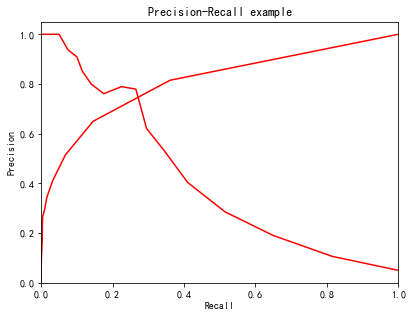

In [69]:
from sklearn.metrics import roc_curve, auc
rcParams['figure.figsize'] = 6.4,4.8
#df_test_predictions = xgb.predict(dtest[predictors])
#df_test_predprob = xgb.predict_proba(dtest[predictors])[:,1]
fpr, tpr, thresholds = roc_curve(df_test[target].values,df_test_predprob)
# Plot Precision-Recall curve
plt.plot(fpr, tpr, color='r')
plt.xlabel('FPR')
plt.ylabel('TPR-Recall')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('ROC')
plt.legend()

from sklearn.metrics import precision_recall_curve
rcParams['figure.figsize'] = 6.4,4.8
precision, recall, thresholds = precision_recall_curve(df_test[target].values,df_test_predprob)
# Plot Precision-Recall curve
plt.plot(recall, precision, color='r')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall example')
plt.legend()